## General Information

This notebook is used to train a simple neural network model to predict the chemistry in the barite benchmark (50x50 grid). The training data is stored in the repository using **git large file storage** and can be downloaded after the installation of git lfs using the `git lfs pull` command.

It is then recommended to create a Python environment using miniconda. The necessary dependencies are contained in `environment.yml` and can be installed using `conda env create -f environment.yml`.

The data set is divided into a design and result part and consists of the iterations of a reference simulation. The design part of the data set contains the chemical concentrations at time $t$ and the result part at time $t+1$, which are to be learned by the model.

## Setup Libraries

In [1]:
import keras
from keras.layers import Dense, Dropout, Input, BatchNormalization
import tensorflow as tf
import h5py
import numpy as np
import pandas as pd
import time
import sklearn.model_selection as sk
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import os
from preprocessing import *
from sklearn import set_config
from importlib import reload
set_config(transform_output = "pandas")

2025-02-14 15:03:29.350232: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-14 15:03:29.368766: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Running Keras in version 3.6.0


In [2]:
%load_ext autoreload
%autoreload 2

## Define parameters

In [3]:
dtype = "float32"
activation = "relu"

lr = 0.001
batch_size = 512
epochs = 50 # default 400 epochs

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=lr,
    decay_steps=2000,
    decay_rate=0.9,
    staircase=True
)

optimizer_simple = keras.optimizers.Adam(learning_rate=lr_schedule)
optimizer_large = keras.optimizers.Adam(learning_rate=lr_schedule)
optimizer_paper = keras.optimizers.Adam(learning_rate=lr_schedule)


loss = keras.losses.Huber()

sample_fraction = 0.8

## Setup the model

In [4]:
# small model
model_simple = keras.Sequential(
    [
        keras.Input(shape = (9,), dtype = "float32"),
        keras.layers.Dense(units = 128, activation = "linear", dtype = "float32"),
        # Dropout(0.2),
        keras.layers.Dense(units = 128, activation = "elu", dtype = "float32"),
        keras.layers.Dense(units = 9, dtype = "float32")
    ]
)

model_simple.compile(optimizer=optimizer_simple, loss = loss)
model_simple.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,953 (74.04 KB)

 Trainable params: 18,953 (74.04 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# large model
model_large =   keras.Sequential(
    [keras.layers.Input(shape=(9,), dtype=dtype),
     keras.layers.Dense(512, activation='relu', dtype=dtype),
     keras.layers.Dense(1024, activation='relu', dtype=dtype),
     keras.layers.Dense(512, activation='relu', dtype=dtype),
     keras.layers.Dense(9, dtype=dtype)
     ])

model_large.compile(optimizer=optimizer_large, loss = loss)
model_large.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 512)            │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,059,849 (4.04 MB)

 Trainable params: 1,059,849 (4.04 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# model from paper
# (see https://doi.org/10.1007/s11242-022-01779-3 model for the complex chemistry)
model_paper =   keras.Sequential(
    [keras.layers.Input(shape=(12,), dtype=dtype),
     keras.layers.Dense(128, activation='relu', dtype=dtype),
     keras.layers.Dense(256, activation='relu', dtype=dtype),
     keras.layers.Dense(512, activation='relu', dtype=dtype),
     keras.layers.Dense(256, activation='relu', dtype=dtype),
     keras.layers.Dense(12, dtype=dtype)
     ])

model_paper.compile(optimizer=optimizer_paper, loss = loss)
model_paper.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 12)             │         3,084 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 300,684 (1.15 MB)

 Trainable params: 300,684 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

## Define transformer functions

In [7]:
def Safelog(val):
    # get range of vector
    if val > 0:
        return np.log10(val)
    elif val < 0:
        return -np.log10(-val)
    else:
        return 0

def Safeexp(val):
    if val > 0:
        return -10 ** -val
    elif val < 0:
        return 10 ** val
    else:
        return 0

In [8]:
# ? Why does the charge is using another logarithm than the other species

func_dict_in = {
    "H" : np.log1p,
    "O" : np.log1p,
    "Charge" : Safelog,
    "H_0_" : np.log1p,
    "O_0_" : np.log1p,
    "Ba" : np.log1p,
    "Cl" : np.log1p,
    "S_2_" : np.log1p,
    "S_6_" : np.log1p,
    "Sr" : np.log1p,
    "Barite" : np.log1p,
    "Celestite" : np.log1p,
}

func_dict_out = {
    "H" : np.expm1,
    "O" : np.expm1,
    "Charge" : Safeexp,
    "H_0_" : np.expm1,
    "O_0_" : np.expm1,
    "Ba" : np.expm1,
    "Cl" : np.expm1,
    "S_2_" : np.expm1,
    "S_6_" : np.expm1,
    "Sr" : np.expm1,
    "Barite" : np.expm1,
    "Celestite" : np.expm1,
}


## Read data from `.h5` file and convert it to a `pandas.DataFrame`

In [9]:
# os.chdir('/mnt/beegfs/home/signer/projects/model-training')
data_file = h5py.File("barite_50_4_corner.h5")

design = data_file["design"]
results = data_file["result"]

df_design = pd.DataFrame(np.array(design["data"]).transpose(), columns = np.array(design["names"].asstr()))
df_results = pd.DataFrame(np.array(results["data"]).transpose(), columns = np.array(results["names"].asstr()))

data_file.close()

In [10]:
species_columns = ['H', 'O', 'Charge', 'Ba', 'Cl', 'S', 'Sr', 'Barite', 'Celestite']

In [11]:
preprocess = preprocessing(func_dict_in=func_dict_in, func_dict_out=func_dict_out)
X, y = preprocess.cluster(df_design[species_columns], df_results[species_columns])
# X, y = preprocess.funcTranform(X, y)

X_train, X_test, y_train, y_test = preprocess.split(X, y, ratio = 0.2)
X_train, y_train = preprocess.balancer(X_train, y_train, strategy = "over")
preprocess.scale_fit(X_train, y_train, scaling = "individual")
X_train, X_test, y_train, y_test = preprocess.scale_transform(X_train, X_test, y_train, y_test)
X_train, X_val, y_train, y_val = preprocess.split(X_train, y_train, ratio = 0.1)

/home/signer/bin/miniconda3/envs/training/lib/python3.11/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Amount class 0 before: 0.9521309523809524
Amount class 1 before: 0.04786904761904762
Using Oversampling
Amount class 0 after: 0.5
Amount class 1 after: 0.5


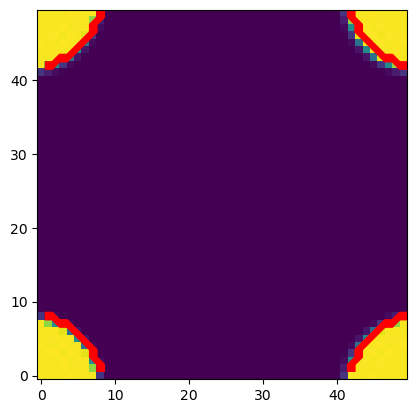

In [12]:
timestep=250
plt.imshow(np.array(X["Barite"][(timestep*2500):(timestep*2500+2500)]).reshape(50,50), origin='lower')
plt.contour(np.array(X["Class"][(timestep*2500):(timestep*2500+2500)]).reshape(50,50), origin='lower', colors='red')


## Preprocess Data

The data are preprocessed in the following way:

1. Label data points in the `design`  dataset with `reactive` and `non-reactive` labels using kmeans clustering
2. Transform `design` and `results` data set into log-scaled data.
3. Split data into training and test sets.
4. Learn scaler on training data for `design` and `results` together (option `global`) or individual (option `individual`).
5. Transform training and test data.
6. Split training data into training and validation dataset.

In [13]:
X_train, X_val, X_test, y_train, y_val, y_test, scaler_X, scaler_y = preprocessing_training(df_design[species_columns], df_results[species_columns], func_dict_in, func_dict_out, "off", 'global', 0.1)

/home/signer/bin/miniconda3/envs/training/lib/python3.11/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


KeyError: 'S'

In [37]:
X_train.iloc[12, :-1].values

array([5.88371754e-02, 2.38285692e-01, 1.25266821e-01, 4.02648011e-05,
       5.71730222e-02, 2.38302374e-01, 9.25432038e-02, 3.77910581e-07,
       9.99694424e-01])

In [44]:
preprocess.scaler_X.inverse_transform(tf.keras.backend.constant(X_train.iloc[12, :-1].values.reshape(1, -1)))

array([[1.11012434e+02, 5.55068087e+01, 3.55966726e-08, 3.89751302e-06,
        1.12795836e-02, 1.47982437e-04, 5.78389634e-03, 9.99927111e-04,
        1.00047941e+00]])

## Custom Loss function

In [12]:
def custom_loss_H20(df_design_log, df_result_log, data_min_log, data_max_log, func_dict_out, postprocess):
    df_result = postprocess(df_result_log, func_dict_out, data_min_log, data_max_log)    
    return keras.losses.Huber + np.sum(((df_result['H'] / df_result['O']) - 2)**2)

def loss_wrapper(data_min_log, data_max_log, func_dict_out, postprocess):
    def loss(df_design_log, df_result_log):
        return custom_loss_H20(df_design_log, df_result_log, data_min_log, data_max_log, func_dict_out, postprocess)
    return loss

In [133]:
column_dict = {"Ba": X.columns.get_loc("Ba"), "Barite":X.columns.get_loc("Barite"), "Sr":X.columns.get_loc("Sr"), "Celestite":X.columns.get_loc("Celestite")}

In [160]:
def custom_loss(preprocess, column_dict):
    def loss(results, predicted):
        
        # predicted = preprocess.funcInverse(predicted)
        # results = preprocess.funcInverse(results)
        # predicted = tf.keras.backend.constant(predicted)
        # results = tf.keras.backend.constant(results)
        
        # predicted = tf.keras.backend.constant(preprocess.scaler_X.inverse_transform(predicted))
        # results = tf.keras.backend.constant(preprocess.scaler_y.inverse_transform(results))
        
        # dBa = tf.keras.backend.abs((predicted["Ba"] + predicted["Barite"]) - (results["Ba"] + results["Barite"]))
        # dSr = tf.keras.backend.abs((predicted["Sr"] + predicted["Celestite"]) - (results["Sr"] + results["Celestite"]))
        # huber_loss = tf.keras.losses.Huber()(results, predicted)
        # total_loss = huber_loss + 0.1 * dBa + 0.1 * dSr
        
        predicted_inverse = predicted * tf.keras.backend.constant(preprocess.scaler_X.scale_) + tf.keras.backend.constant(preprocess.scaler_X.min_)
        results_inverse = results * tf.keras.backend.constant(preprocess.scaler_y.scale_) + tf.keras.backend.constant(preprocess.scaler_y.min_)
        
        dBa = tf.keras.backend.abs((predicted_inverse[:,column_dict["Ba"]] + predicted_inverse[:, column_dict["Barite"]]) - (results_inverse[:, column_dict["Ba"]] + results_inverse[:, column_dict["Barite"]]))
        dSa = tf.keras.backend.abs((predicted_inverse[:,column_dict["Sr"]] + predicted_inverse[:, column_dict["Celestite"]]) - (results_inverse[:, column_dict["Sr"]] + results_inverse[:, column_dict["Celestite"]]))
        
        huber_loss = tf.keras.losses.Huber()(results, predicted)
        total_loss = huber_loss # + 0.1 * dBa + 0.1 * dSa
        
        return total_loss

    return loss



In [165]:
model_simple.compile(optimizer=optimizer_simple, loss=loss)#custom_loss(preprocess, column_dict))

## Train the model

In [166]:
preprocess.scaler_X.scale_

array([1.15182858e+07, 4.02793041e+02, 1.88096044e+06, 1.03308956e+01,
       5.06871734e+00, 1.61113403e+03, 1.74937705e+01, 9.88625768e-01,
       9.99215371e-01])

In [167]:
# measure time
def model_training(model):
    start = time.time()
    callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    history = model.fit(X_train.loc[:, X_train.columns != "Class"], 
                        y_train.loc[:, y_train.columns != "Class"], 
                        batch_size=batch_size, 
                        epochs=20, 
                        validation_data=(X_val.loc[:, X_val.columns != "Class"], y_val.loc[:, y_val.columns != "Class"]),
                        callbacks=[callback])

    end = time.time()

    print("Training took {} seconds".format(end - start))

In [168]:
model_training(model_simple)

Epoch 1/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.8797e-04 - val_loss: 2.8113e-04
Epoch 2/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.8380e-04 - val_loss: 2.7753e-04
Epoch 3/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.8036e-04 - val_loss: 2.7414e-04
Epoch 4/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.7782e-04 - val_loss: 2.7140e-04
Epoch 5/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.7578e-04 - val_loss: 2.6949e-04
Epoch 6/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.7396e-04 - val_loss: 2.6790e-04
Epoch 7/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.7167e-04 - val_loss: 2.6644e-04
Epoch 8/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.6910e-04 - val_loss: 2.6501e-04
Epoch 9/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.6823e-04 - val_loss: 2.6271e-04
Epoch 10/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.6424e-04 - val_loss: 2.5818e-04
Epoch 11/20
1688/1688 ━━━━━━━━━━━━━━━━━

## Test Mass Balance

In [98]:
def mass_balance(model, X, preprocess):
    
    # predict the chemistry
    columns = X.iloc[:, X.columns != "Class"].columns
    prediction = pd.DataFrame(model.predict(X[columns]), columns=columns)
    # backtransform min/max
    X = pd.DataFrame(preprocess.scaler_X.inverse_transform(X.iloc[:, X.columns != "Class"]), columns=columns)
    prediction = pd.DataFrame(preprocess.scaler_y.inverse_transform(prediction), columns=columns)
    
    # backtransform log
    if(preprocess.state['log'] == True):
        X, prediction = preprocess.funcInverse(X, prediction)
        
    # calculate mass balance
    dBa = np.abs((prediction["Ba"] + prediction["Barite"]) - (X["Ba"] + X["Barite"]))
    dSr = np.abs((prediction["Sr"] + prediction["Celestite"]) - (X["Sr"] + X["Celestite"]))
    
    return dBa + dSr

In [99]:
mass_balance_results = mass_balance(model_simple, X_train, preprocess)

26993/26993 ━━━━━━━━━━━━━━━━━━━━ 10s 358us/step


In [100]:
len(mass_balance_results[mass_balance_results < 1e-5]) / len(mass_balance_results)

0.0

In [101]:
mass_balance_results[mass_balance_results < 1e-5]

Series([], dtype: float64)

### Percentage of cells that pass the mass balance condition

small_modell_20_epochs = 0.0031088911088911087

large_modell_20_epochs = 0.022793206793206792

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step


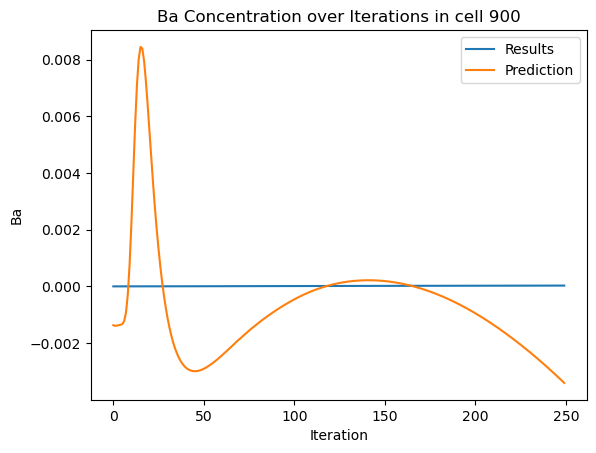

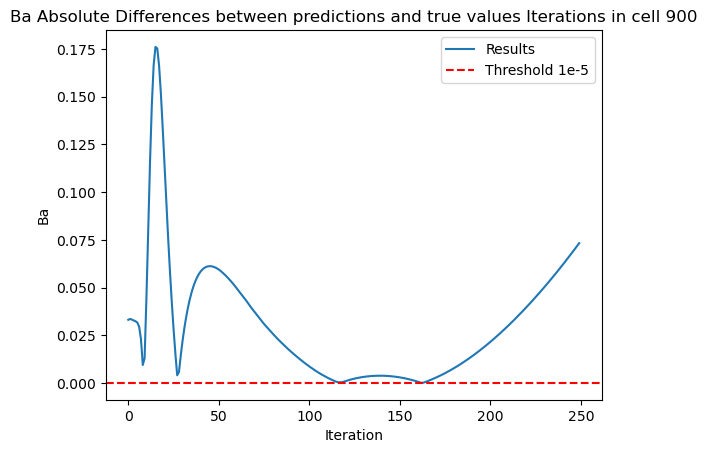

In [102]:
import matplotlib.pyplot as plt

species = "Ba"
iterations = 250
cell_offset = 900
y_design = []
y_results = []
y_differences = []

# if(preprocess.state['log'] == True):
#     df_design_transformed, df_results_transformed = preprocess.funcTranform(df_design[species_columns], df_results[species_columns])

df_design_transformed_scaled = preprocess.scaler_X.transform(df_design[species_columns])
df_results_transformed_scaled = preprocess.scaler_y.transform(df_results[species_columns])

for i in range(0,iterations):
    idx = i*50*50 + cell_offset-1
    y_design.append(df_design_transformed_scaled.iloc[idx, :])
    y_results.append(df_results_transformed_scaled.iloc[idx,:])
    
y_design = pd.DataFrame(y_design)
y_results = pd.DataFrame(y_results)

prediction = model_simple.predict(y_design.iloc[:, y_design.columns != "Class"])
prediction = pd.DataFrame(prediction, columns = y_results.columns)

# y_results_back, prediction = preprocess.funcInverse(y_results, prediction)

y_results_back = pd.DataFrame(preprocess.scaler_y.inverse_transform(y_results), columns = species_columns)
prediction_back = pd.DataFrame(preprocess.scaler_X.inverse_transform(prediction), columns = species_columns)


plt.plot(np.arange(0,iterations), y_results_back[species], label = "Results")
plt.plot(np.arange(0,iterations), prediction_back[species], label = "Prediction")
plt.legend()
plt.xlabel('Iteration')
plt.ylabel(species)
plt.title(species+' Concentration over Iterations in cell ' + str(cell_offset))
plt.legend()
plt.show()


mass_balance = np.abs((prediction_back["Ba"] + prediction_back["Barite"]) - (y_results_back["Ba"] + y_results_back["Barite"])) \
    + np.abs((prediction_back["Sr"] + prediction_back["Celestite"]) - (y_results_back["Sr"] + y_results_back["Celestite"]))
plt.plot(np.arange(0,iterations), mass_balance, label = "Results")
plt.xlabel('Iteration')
plt.ylabel(species)
plt.title(species+' Absolute Differences between predictions and true values Iterations in cell ' + str(cell_offset))
plt.axhline(y=1e-5, color='r', linestyle='--', label='Threshold 1e-5')
plt.legend()


plt.show()

In [ ]:
y

H          O        Charge            Ba        Cl  \
0    111.012434  55.510420 -5.285676e-07  4.536952e-07  0.000022   
1    111.012434  55.507697 -5.292985e-07  1.091671e-06  0.002399   
2    111.012434  55.506335 -5.311407e-07  6.816584e-05  0.008922   
3    111.012434  55.506229 -5.326179e-07  1.435037e-03  0.017414   
4    111.012434  55.506224 -5.354202e-07  3.264876e-03  0.026235   
..          ...        ...           ...           ...       ...   
995  111.012434  55.506217 -5.369526e-07  6.381593e-02  0.223770   
996  111.012434  55.506217 -5.370535e-07  6.386712e-02  0.223789   
997  111.012434  55.506217 -5.371457e-07  6.391481e-02  0.223807   
998  111.012434  55.506217 -5.372196e-07  6.395922e-02  0.223826   
999  111.012434  55.506217 -5.372770e-07  6.400057e-02  0.223844   

             S_6_        Sr    Barite  Celestite  
0    1.050707e-03  0.000625  0.001010   1.717461  
1    3.700427e-04  0.001488  0.001738   1.716139  
2    2.946349e-05  0.004445  0.004898   1.708478  
3    3.035681e-06  0.007281  0.008778   1.698481  
4    1.872898e-06  0.009764  0.012641   1.688408  
..            ...       ...       ...        ...  
995  1.220403e-07  0.032096  1.714723   0.000000  
996  1.220029e-07  0.032055  1.714723   0.000000  
997  1.219644e-07  0.032017  1.714723   0.000000  
998  1.219672e-07  0.031982  1.714723   0.000000  
999  1.220142e-07  0.031950  1.714723   0.000000  

[1000 rows x 9 columns]

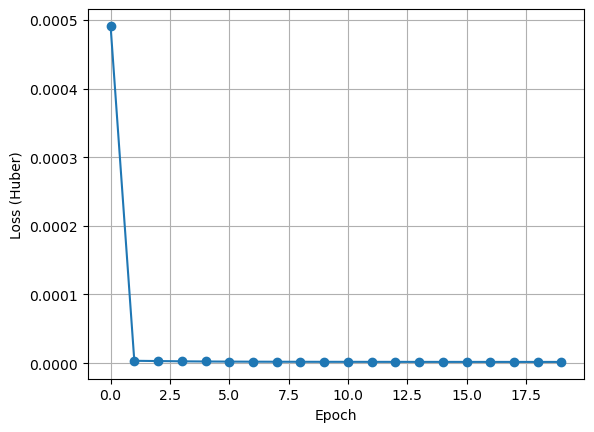

In [25]:
plt.plot(history.history["loss"], "o-", label = "Training Loss")
plt.xlabel("Epoch")
# plt.yscale('log')
plt.ylabel("Loss (Huber)")
plt.grid('on')

plt.savefig("loss_all.png", dpi=300)


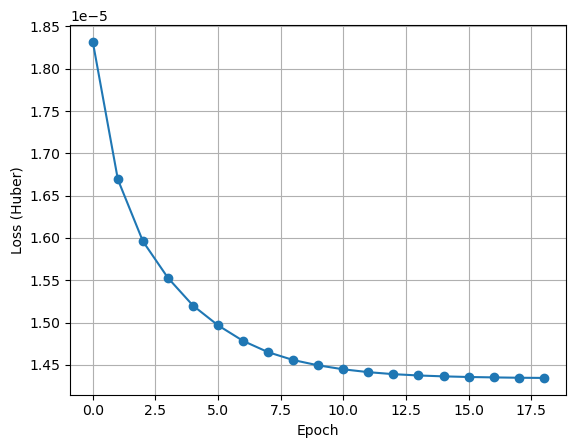

In [14]:
plt.plot(history.history["loss"][1:], "o-", label = "Training Loss")
plt.xlabel("Epoch")
# plt.yscale('log')
plt.ylabel("Loss (Huber)")
plt.grid('on')
plt.savefig("loss_1_to_end.png", dpi=300)


## Test the model

In [48]:
# test on all test data
model_simple.evaluate(X_test.loc[:, X_test.columns != "Class"], y_test.loc[:, y_test.columns != "Class"])

15641/15641 ━━━━━━━━━━━━━━━━━━━━ 6s 351us/step - loss: 5.1847e-07


3.571243496480747e-07

In [49]:
# test on non-reactive data
model_simple.evaluate(X_test[X_test['Class'] == 0].iloc[:,X_test.columns != "Class"], y_test[X_test['Class'] == 0].iloc[:, y_test.columns != "Class"])

15452/15452 ━━━━━━━━━━━━━━━━━━━━ 6s 385us/step - loss: 5.2313e-07


3.601293485644419e-07

In [17]:
mass_balance = mass_balance(model_simple, X_test, scaler_X, func_dict_in, func_dict_out)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0710e-05


In [50]:
# test on reactive data
model_simple.evaluate(X_test[X_test['Class'] == 1].iloc[:,:-1], y_test[X_test['Class'] == 1].iloc[:, :-1])

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 1.2226e-07


1.1114495634956256e-07

## Save the model

In [53]:
# Save the model
model.save("Barite_50_Model_additional_species.keras")